In [1]:
# %load honest_net.py
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/honest_net.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


# C&P from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except TypeError:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    d = {}

    def wsg(k, v):
        d[k + "_weakest"] = v[weakest]
        d[k + "_strongest"] = v[strongest]
        d[k + "_gini"] = gini(v)

    rcompute = compute / np.sum(compute)
    wsg("compute", rcompute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / np.sum(activations)
    wsg("activations", ractivations)
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    wsg("reward", rreward)
    efficiency = rreward / ractivations
    wsg("efficiency", efficiency)
    d["activations_compute_gini_delta"] = d["activations_gini"] - d["compute_gini"]
    d["reward_activations_gini_delta"] = d["reward_gini"] - d["activations_gini"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

## Incentive Schemes for Georges  Protocol

In [2]:
d = df[df.protocol == "tailstorm"]

### Efficiency of the weakest miner

We pick the weakest miner by compute power and calculate its

efficiency = relative reward / relative activations

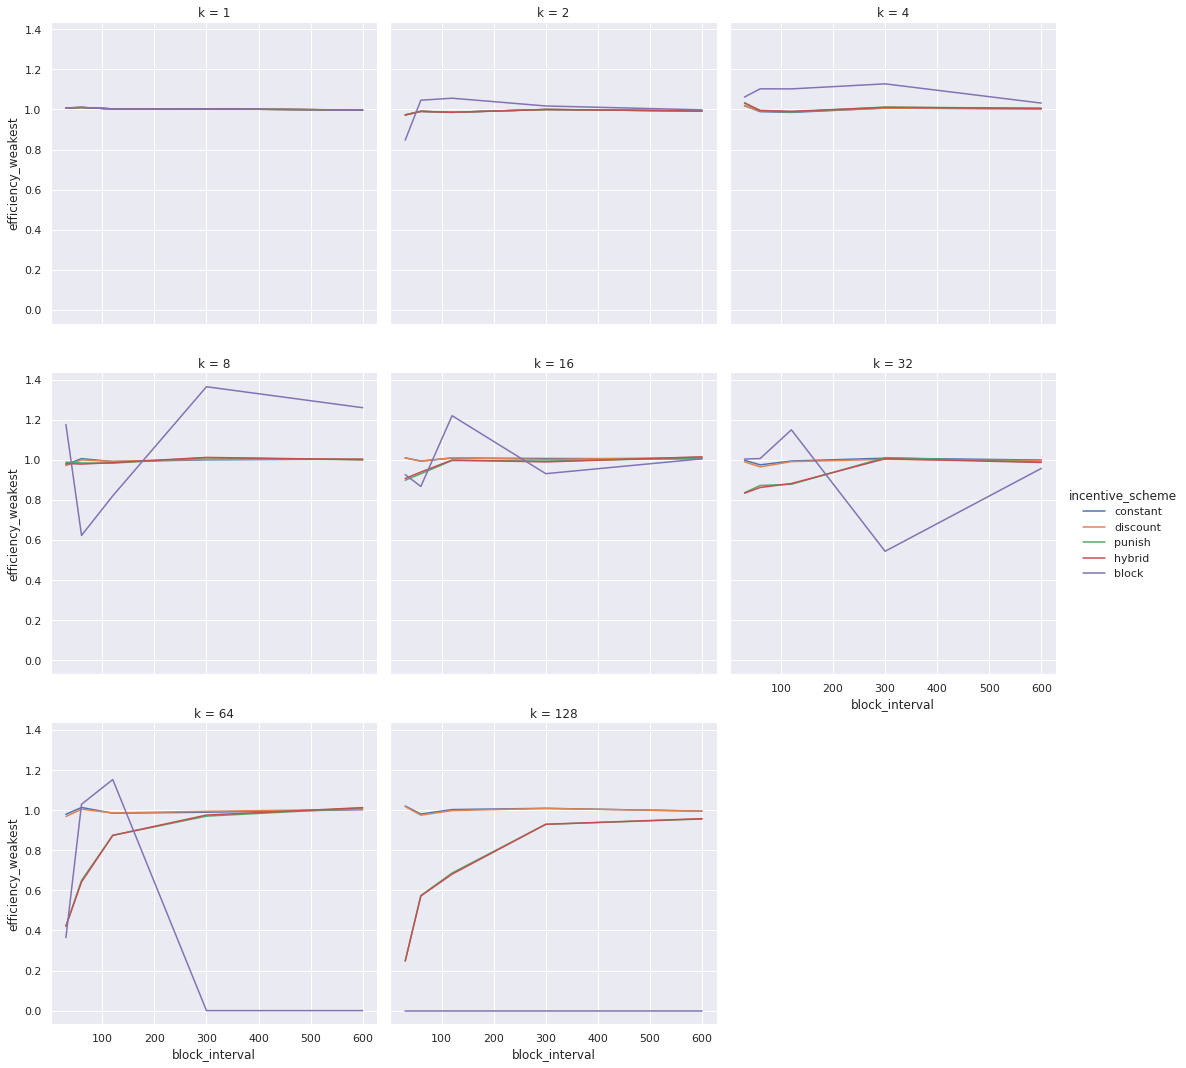

In [3]:
sns.relplot(
    data=d,
    x="block_interval",
    y="efficiency_weakest",
    col="k",
    col_wrap=3,
    hue="incentive_scheme",
    kind="line",
)

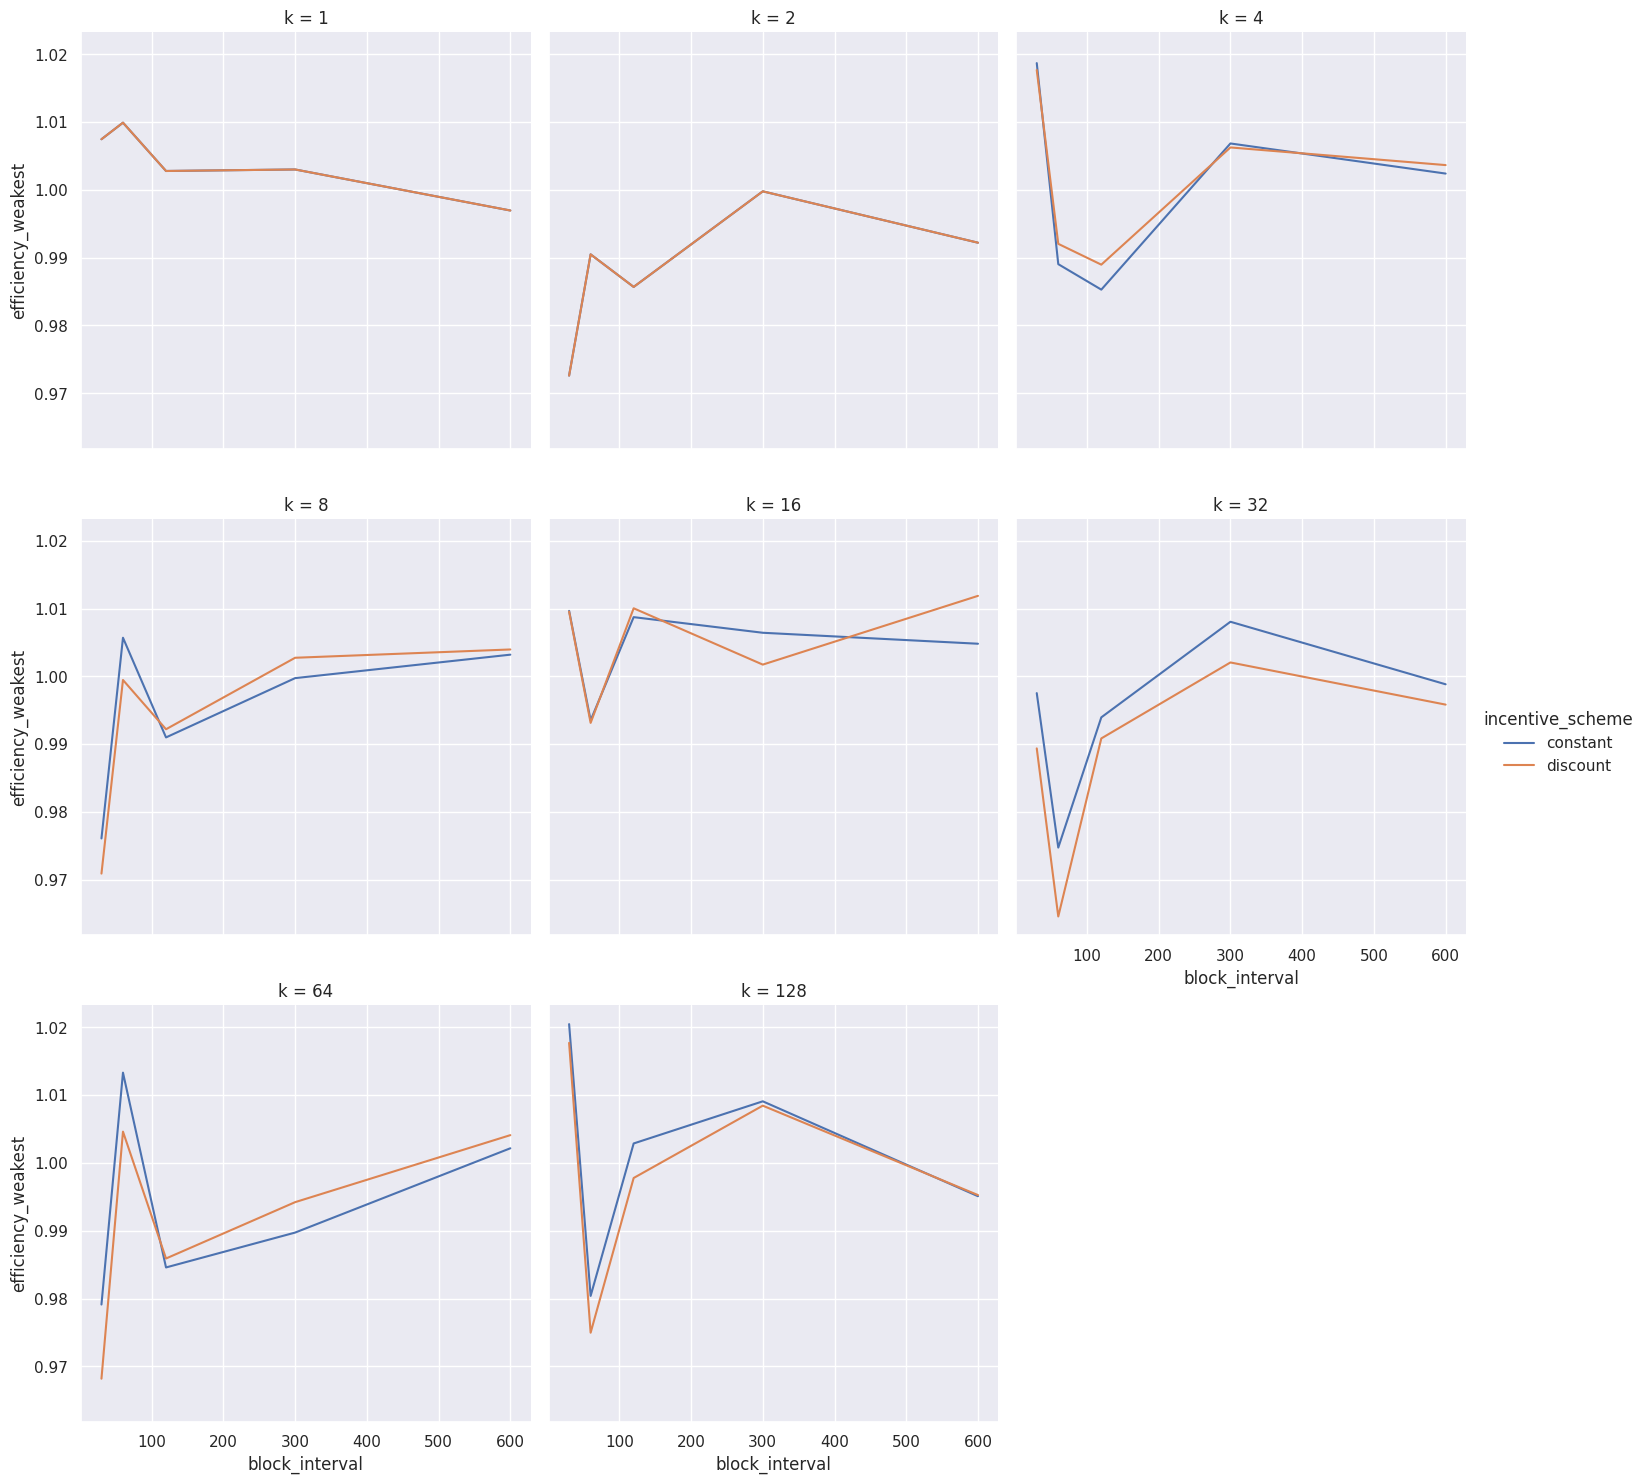

In [4]:
sns.relplot(
    data=d[
        (d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")
    ],
    x="block_interval",
    y="efficiency_weakest",
    col="k",
    col_wrap=3,
    hue="incentive_scheme",
    kind="line",
)

In [5]:
eff = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k"],
    columns=["Incentive Scheme"],
    values="efficiency_weakest",
)
eff.style.to_latex(buf="../../tex/george-reward-inequality/tab/efficiency-weakest.tex")
eff

Incentive Scheme       block  constant  discount    hybrid    punish
Block Interval k                                                    
30.0           1    1.007468  1.007468  1.007468  1.007468  1.007468
               2    0.846740  0.972607  0.972607  0.972607  0.972607
               4    1.061917  1.018700  1.017686  1.030946  1.033943
               8    1.176028  0.976103  0.970920  0.981391  0.987835
               16   0.926069  1.009672  1.009561  0.906776  0.897868
               32   1.003814  0.997541  0.989387  0.833484  0.835952
               64   0.364325  0.979124  0.968185  0.421480  0.421270
               128  0.000000  1.020482  1.017717  0.247536  0.247223
60.0           1    1.009913  1.009913  1.009913  1.009913  1.009913
               2    1.046136  0.990490  0.990490  0.990490  0.990490
               4    1.102935  0.989045  0.992041  0.995322  0.993584
               8    0.622582  1.005709  0.999476  0.978535  0.984099
               16   0.867077  0.993526  0.993150  0.938935  0.930519
               32   1.006198  0.974754  0.964594  0.861677  0.871703
               64   1.029407  1.013322  1.004623  0.641771  0.649269
               128  0.000000  0.980392  0.974965  0.571923  0.573737
120.0          1    1.002787  1.002787  1.002787  1.002787  1.002787
               2    1.056093  0.985686  0.985686  0.985686  0.985686
               4    1.102582  0.985286  0.988971  0.990625  0.987483
               8    0.820143  0.991006  0.992209  0.985825  0.983324
               16   1.219878  1.008746  1.010050  0.998832  0.996390
               32   1.149646  0.993964  0.990857  0.881667  0.877963
               64   1.152693  0.984592  0.985913  0.874146  0.874499
               128  0.000000  1.002881  0.997787  0.680718  0.686429
300.0          1    1.003009  1.003009  1.003009  1.003009  1.003009
               2    1.017325  0.999785  0.999785  0.999785  0.999785
               4    1.127668  1.006847  1.006260  1.010171  1.012043
               8    1.364366  0.999751  1.002754  1.011835  1.010226
               16   0.930813  1.006441  1.001744  0.989331  0.993791
               32   0.543675  1.008065  1.002062  1.005084  1.010868
               64   0.000000  0.989736  0.994223  0.975555  0.970039
               128  0.000000  1.009096  1.008457  0.929409  0.929335
600.0          1    0.996958  0.996958  0.996958  0.996958  0.996958
               2    0.998012  0.992210  0.992210  0.992210  0.992210
               4    1.031716  1.002406  1.003657  1.005704  1.005126
               8    1.259845  1.003210  1.003977  1.000721  0.999567
               16   1.004823  1.004823  1.011884  1.014927  1.008272
               32   0.956974  0.998842  0.995843  0.986731  0.988414
               64   0.000000  1.002169  1.004107  1.012408  1.010805
               128  0.000000  0.995099  0.995271  0.957560  0.955728

### Reward Gini Fairness

We compare the rewards of all miners using the Gini coefficient. A lower coefficient implies more fairness. All numbers should be compared to the Gini coefficient of the compute powers.

In [6]:
d.compute_gini.unique()

array([0.3])

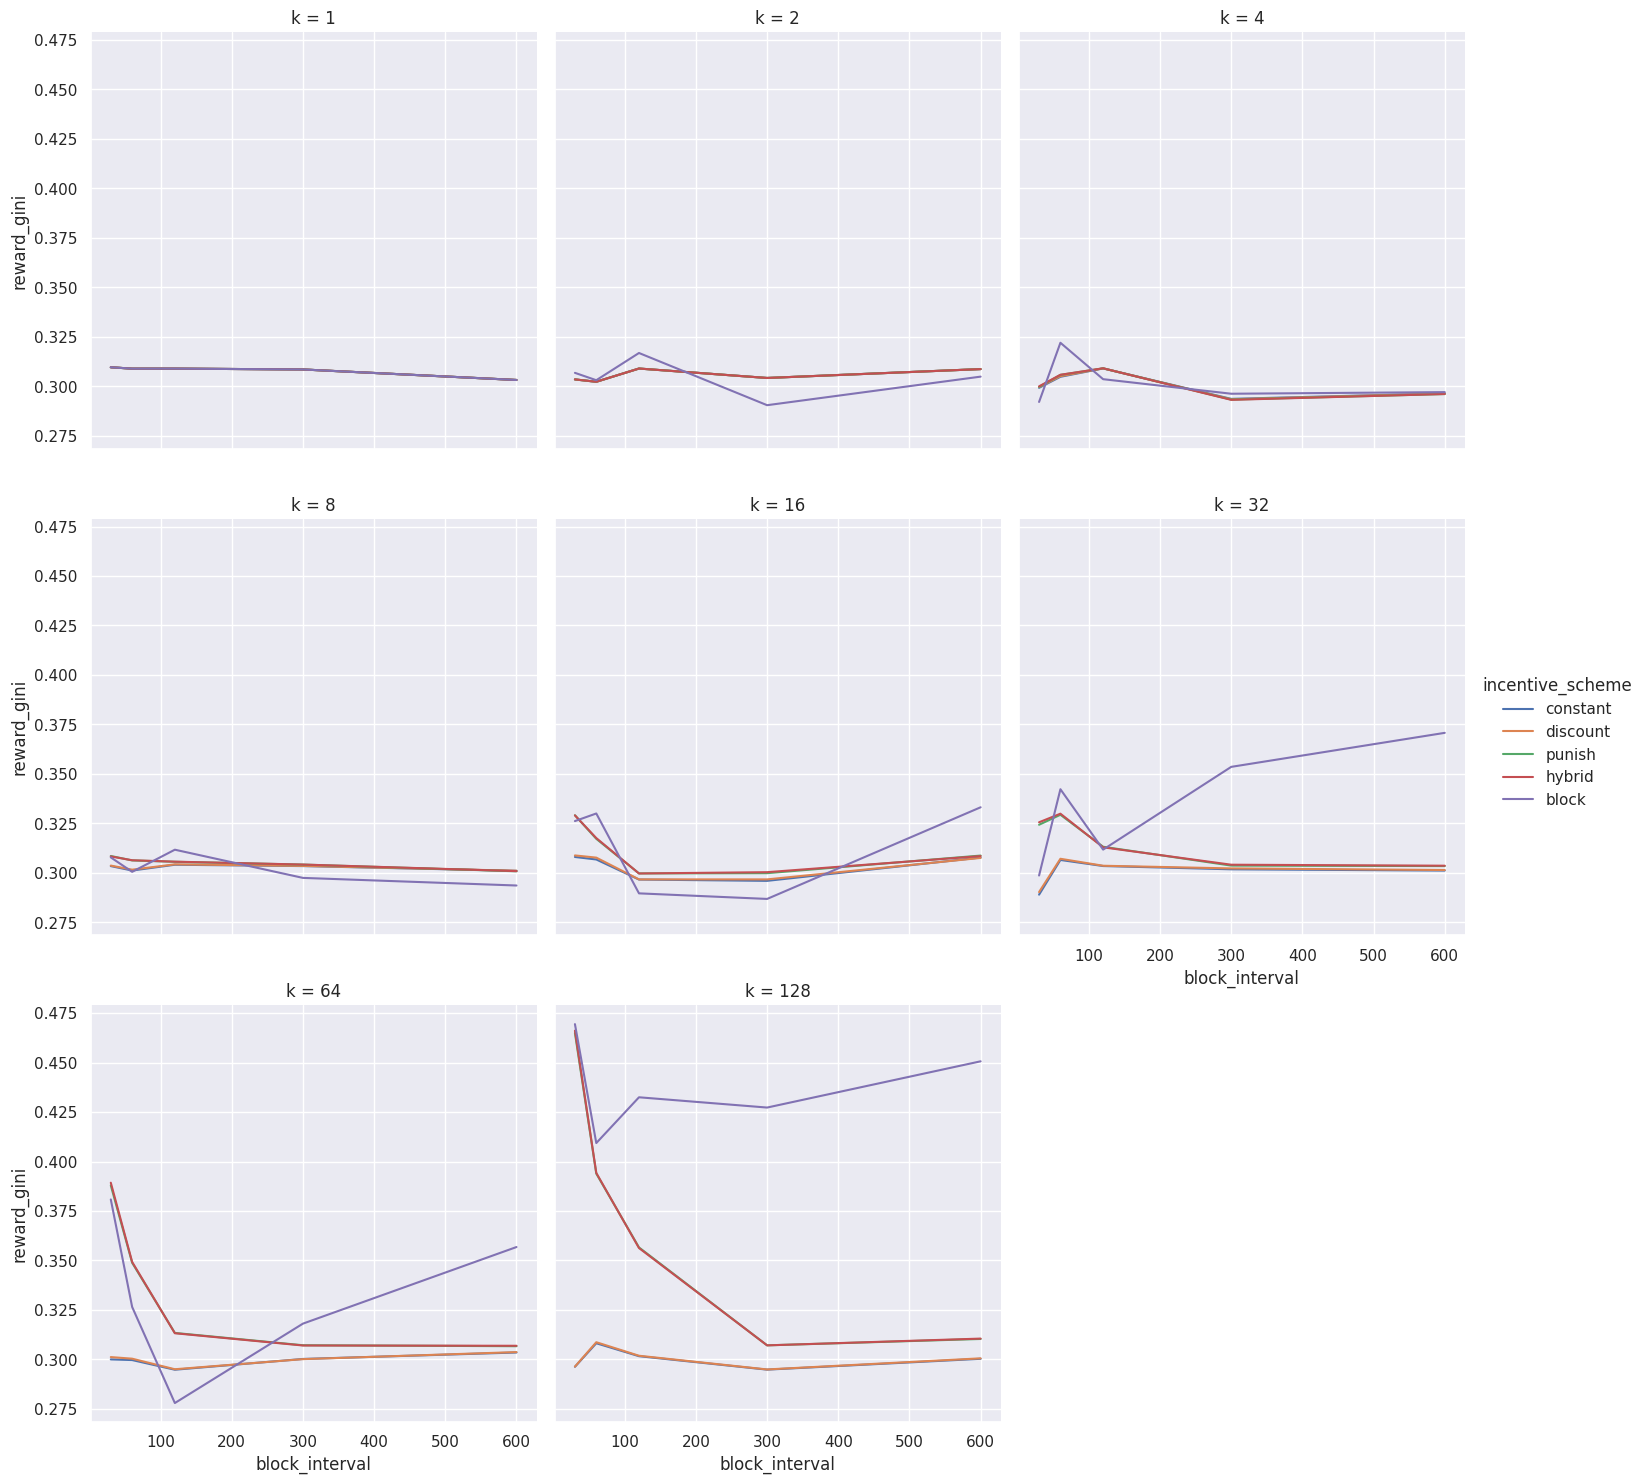

In [7]:
sns.relplot(
    data=d,
    x="block_interval",
    y="reward_gini",
    col="k",
    col_wrap=3,
    hue="incentive_scheme",
    kind="line",
)

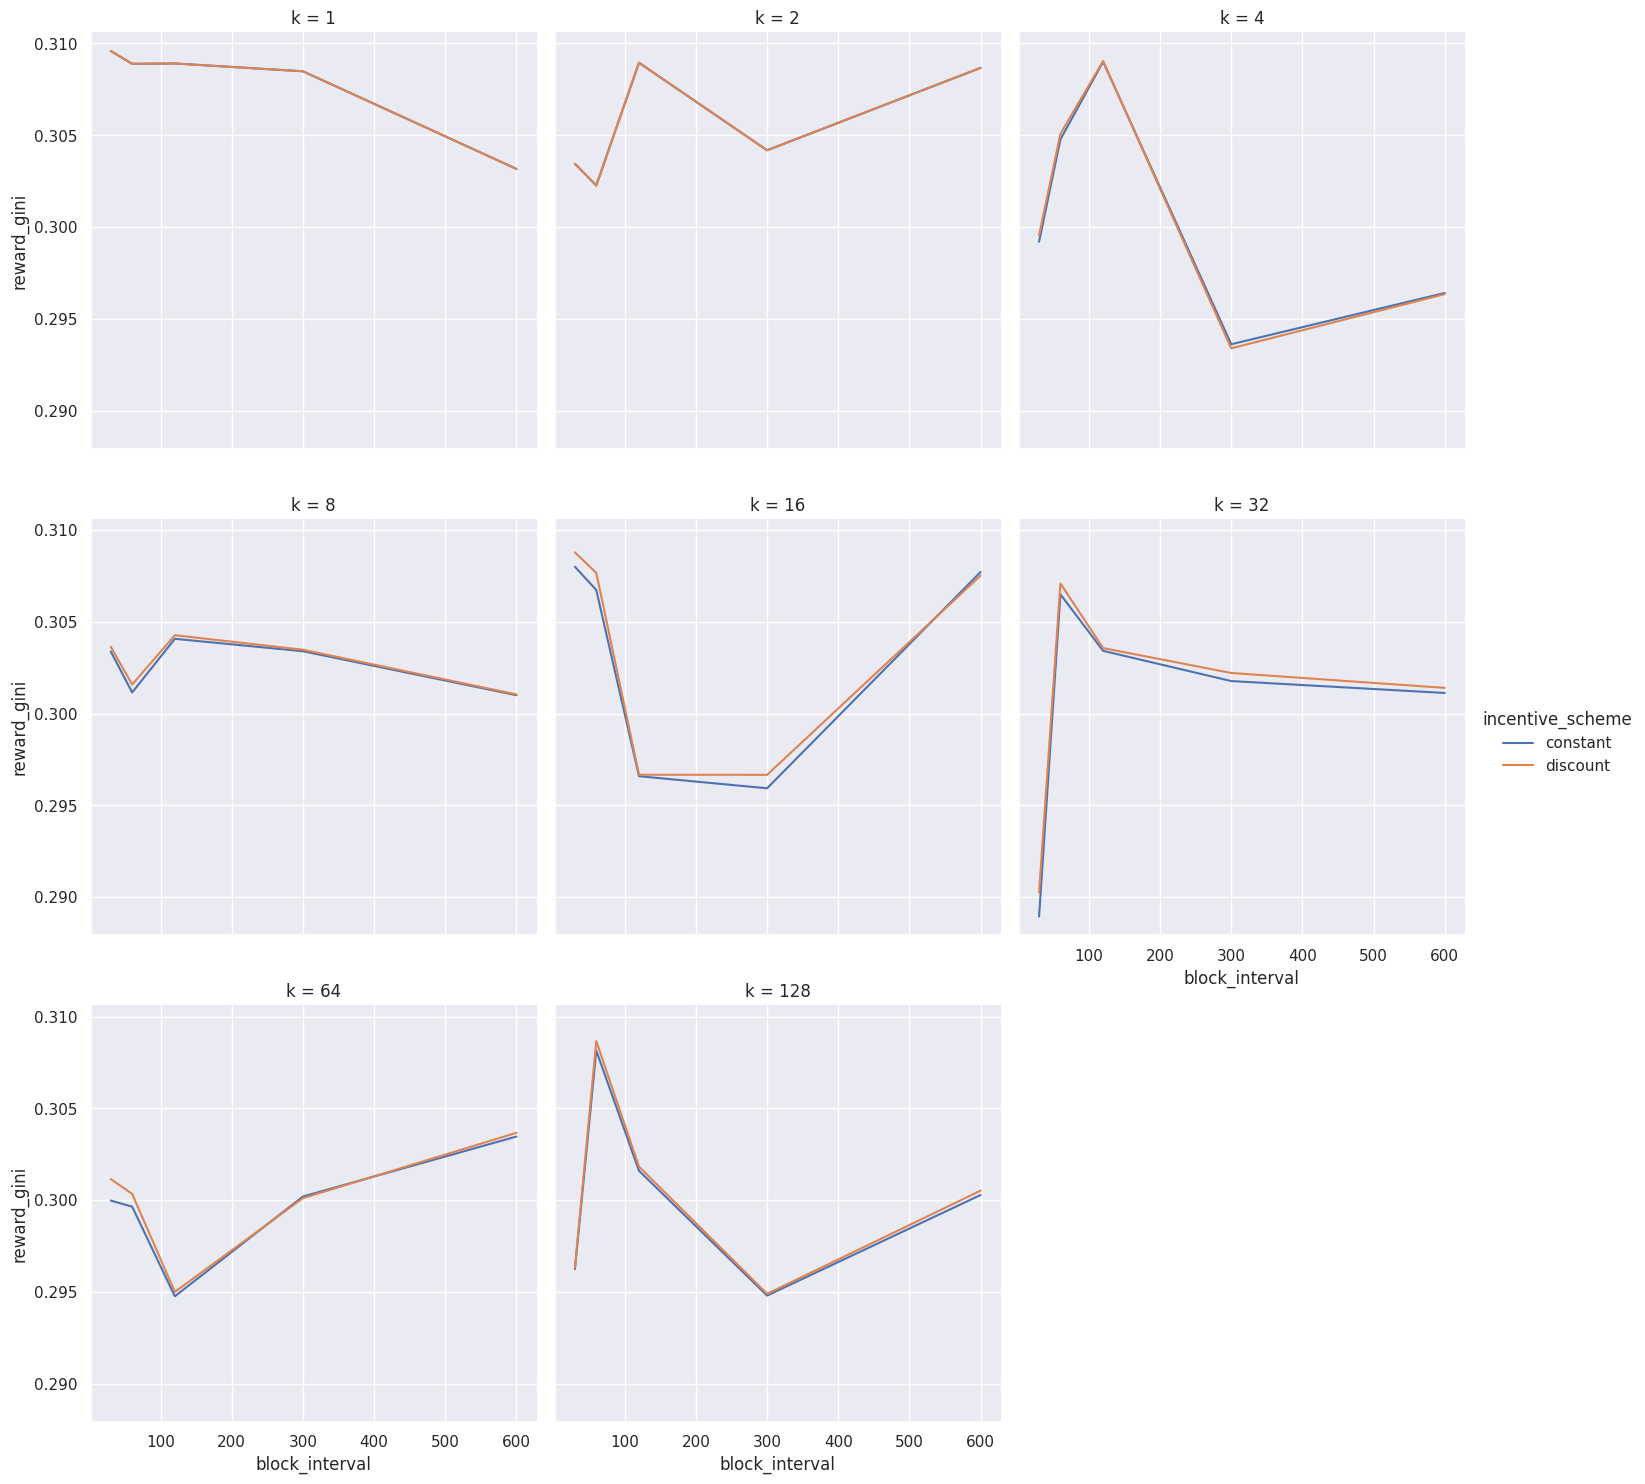

In [8]:
sns.relplot(
    data=d[
        (d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")
    ],
    x="block_interval",
    y="reward_gini",
    col="k",
    col_wrap=3,
    hue="incentive_scheme",
    kind="line",
)

In [9]:
gini = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k"],
    columns=["Incentive Scheme"],
    values="reward_gini",
)
gini.style.to_latex(buf="../../tex/george-reward-inequality/tab/reward-gini.tex")
gini

Incentive Scheme       block  constant  discount    hybrid    punish
Block Interval k                                                    
30.0           1    0.309590  0.309590  0.309590  0.309590  0.309590
               2    0.306774  0.303450  0.303450  0.303450  0.303450
               4    0.292061  0.299198  0.299555  0.299948  0.299666
               8    0.307790  0.303387  0.303641  0.308278  0.308501
               16   0.326146  0.308001  0.308784  0.329025  0.329088
               32   0.298635  0.288951  0.290255  0.325535  0.324285
               64   0.380822  0.299979  0.301149  0.389298  0.387911
               128  0.469444  0.296246  0.296328  0.466141  0.464984
60.0           1    0.308893  0.308893  0.308893  0.308893  0.308893
               2    0.303047  0.302265  0.302265  0.302265  0.302265
               4    0.321976  0.304777  0.305081  0.305794  0.305741
               8    0.300494  0.301153  0.301584  0.306341  0.306258
               16   0.329984  0.306734  0.307670  0.317557  0.317185
               32   0.342244  0.306498  0.307090  0.329881  0.329335
               64   0.326490  0.299648  0.300344  0.349241  0.348818
               128  0.409333  0.308146  0.308666  0.394234  0.393903
120.0          1    0.308911  0.308911  0.308911  0.308911  0.308911
               2    0.316809  0.308952  0.308952  0.308952  0.308952
               4    0.303571  0.309010  0.309041  0.309071  0.309056
               8    0.311679  0.304075  0.304270  0.305627  0.305567
               16   0.289610  0.296591  0.296671  0.299659  0.299689
               32   0.311726  0.303420  0.303569  0.312879  0.313164
               64   0.277922  0.294765  0.295002  0.313204  0.313358
               128  0.432468  0.301603  0.301828  0.356269  0.356576
300.0          1    0.308485  0.308485  0.308485  0.308485  0.308485
               2    0.290426  0.304183  0.304183  0.304183  0.304183
               4    0.296214  0.293617  0.293396  0.293127  0.293260
               8    0.297426  0.303399  0.303481  0.304171  0.304150
               16   0.286795  0.295934  0.296666  0.300317  0.299811
               32   0.353548  0.301774  0.302214  0.304090  0.303642
               64   0.318065  0.300202  0.300114  0.307006  0.307132
               128  0.427273  0.294805  0.294900  0.307073  0.307082
600.0          1    0.303168  0.303168  0.303168  0.303168  0.303168
               2    0.304858  0.308673  0.308673  0.308673  0.308673
               4    0.297033  0.296411  0.296346  0.296082  0.296060
               8    0.293579  0.301003  0.301047  0.300848  0.300769
               16   0.333119  0.307717  0.307522  0.308451  0.308714
               32   0.370740  0.301125  0.301403  0.303585  0.303405
               64   0.356774  0.303468  0.303671  0.306866  0.306651
               128  0.450649  0.300284  0.300521  0.310494  0.310305